### Описание эксперимента

- **Продукт:** SaaS, подписка, аналитика в соц. сетях. Пользователь может отслеживать свою активность и своих друзей, подписавшись в сервисе
- **Тестируемое изменение:** изменение заголовка и подписи в кнопке на первом экране главной страницы. Цель – зацепить пользователя и не дать ему уйти с сайта

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.power import tt_ind_solve_power
from scipy.stats import shapiro, bartlett

# 1. Загрузка и предобработка данных

In [2]:
#Загрузка данных
data = pd.read_csv("test_analyst_ab.csv", sep = ";", index_col= 0)

In [3]:
data.head()

,date,deviceCategory,sourceMedium,experimentVariant,clickButtonOnMain,sessionDuration
1,2019-11-27,desktop,(direct) / (none),control,1,"123,109764978127"
2,2019-11-27,mobile,maz.com / referral,test,1,"135,604000573899"
3,2019-11-27,mobile,(direct) / (none),test,1,"134,451016589043"
4,2019-11-27,desktop,google / organic,test,1,"130,691086592426"
5,2019-11-27,mobile,google / organic,control,1,"117,617311178722"


In [4]:
#Проверка типов фичей. Видно, что колонка "date" имеет тип не дата, а объект. 
#Также переменная "sessionDuration" должна быть типом float.
data.dtypes

date                 object
deviceCategory       object
sourceMedium         object
experimentVariant    object
clickButtonOnMain     int64
sessionDuration      object
dtype: object

In [5]:
#Проверка пропущенных значений
data.isna().sum()

date                 0
deviceCategory       0
sourceMedium         0
experimentVariant    0
clickButtonOnMain    0
sessionDuration      0
dtype: int64

In [6]:
#Меняем тип переменных 'sessionDuration' и "date" на нужные.
data['sessionDuration'] = data['sessionDuration'].str.replace(',', '.').astype('float')
data["date"] = pd.to_datetime(data['date'],format='%Y-%m-%d')

In [7]:
#Смотрим изменения
data.head()

,date,deviceCategory,sourceMedium,experimentVariant,clickButtonOnMain,sessionDuration
1,2019-11-27,desktop,(direct) / (none),control,1,123.109765
2,2019-11-27,mobile,maz.com / referral,test,1,135.604001
3,2019-11-27,mobile,(direct) / (none),test,1,134.451017
4,2019-11-27,desktop,google / organic,test,1,130.691087
5,2019-11-27,mobile,google / organic,control,1,117.617311


# 2. Дизайн эксперимента

В данном экперименте тестируются сразу два изменения: изменение заголовка и подписи в кнопке на первом экране главной страницы. 
Основная гипотеза заключается в том, что данное изменение зацепит пользователя. 
 
Так как цель изменений - зацепить пользователя и не дать ему уйти с сайта, то целевой метрикой будет время проведенное на сайте в рамках сеанса. Данные уже собраны, так что продумывать систему сплитования или длительность эксперимента не нужно. 

Нулевая гипотеза заключается в том, что изменения интерфейса увеличит среднее время пользователя на сайте на 10%. Альтерантивная гипотеза заключается в том, что данное изменение увеличило среднее время пользователя меньше чем на 10%. 
 
Уровень значимости, при котором будет отвергаться нулевая гипотеза - 5%. Если в 95% интервал распределения средних значений 
разниц средних не будет попадать 0.1, значит эффект от изменений меньше 10% и такое изменение не сильно увеличит нашу прибыль. 

## 2.1. Опеределние объёма выборки 

Необходимо провести расчёт минимального размера выборки. Посчитаем среднее в нашей контрольной группе и стандартное отклонение. Хотим, чтобы среднее увеличилось в 10%, с таким же стандартным отклонением

In [8]:
mean_control = data[data["experimentVariant"]=="control"]["sessionDuration"].mean()
std_control = data[data["experimentVariant"]=="control"]["sessionDuration"].std()

In [9]:
std_control

5.18345178179293

In [10]:
cohens_d = (mean_control*1.1 - mean_control) / (np.sqrt((std_control ** 2 + std_control ** 2) / 2))
cohens_d

2.315793503031794

In [11]:
tt_ind_solve_power(effect_size = cohens_d ,alpha = 0.05, power = 0.8)

4.146636699653668

Чтобы с 80% точностью заметить изменение в 10% нам необходимо всего лишь 4 наблюдения в обоих группах, значит нашего объёма выборки достаточно.


## 2.2. Исследование целевой переменной

Text(0.5, 1.0, 'Распределение длительности сессии в контрольной и тестовой группе')

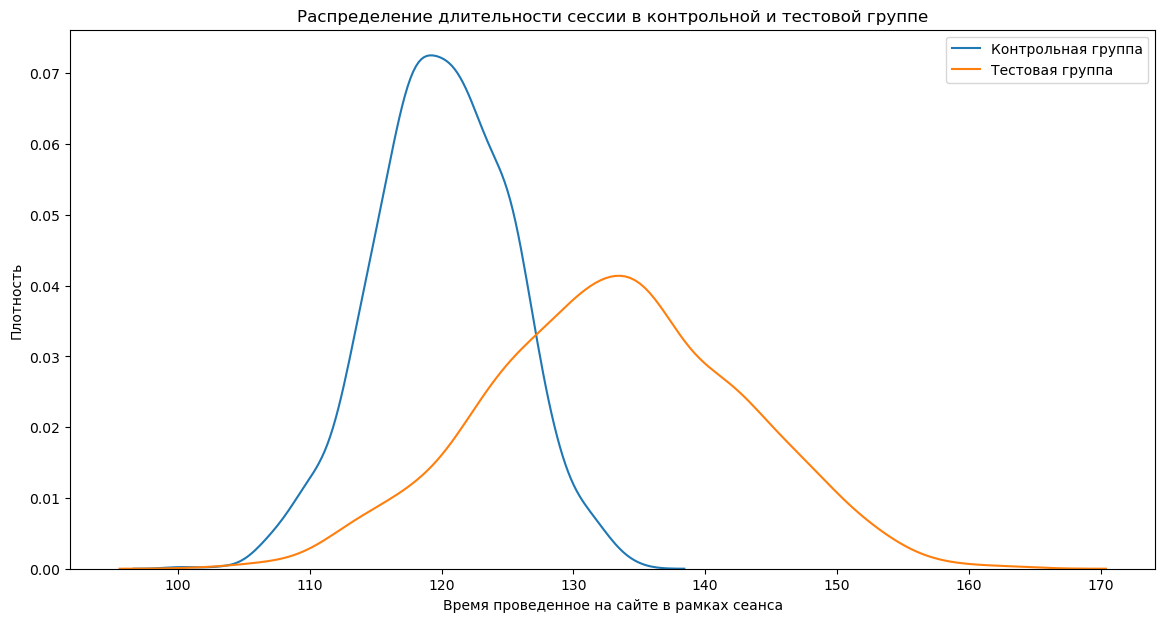

In [12]:
#Глядя на распределение целевой переменной в разрезе тестовой и контрольной группы уже можно заметить отличающееся распределение
plt.figure(figsize = (14,7))
sns.kdeplot(x = 'sessionDuration', data = data[data['experimentVariant'] == "control"])
sns.kdeplot(x = 'sessionDuration', data = data[data['experimentVariant'] == "test"])
plt.legend(["Контрольная группа","Тестовая группа"])
plt.xlabel("Время проведенное на сайте в рамках сеанса")
plt.ylabel("Плотность")
plt.title("Распределение длительности сессии в контрольной и тестовой группе")

Проверим распределение целевой переменной в тестовой и контрольной группах на нормалдьность с помощью теста Шапиро - Вилка

In [13]:
shapiro(data[data['experimentVariant'] == "control"]["sessionDuration"])

ShapiroResult(statistic=0.9982960820198059, pvalue=0.13837692141532898)

In [14]:
shapiro(data[data['experimentVariant'] == "test"]["sessionDuration"])

ShapiroResult(statistic=0.9987943768501282, pvalue=0.4304580092430115)

В обеих группах нулевая гипотеза о нормальности распределения не отвергается на уровне в 10%, поэтому можно использовать T-test для тестирования гипотезы.
 


## 2.2. Анализ сегментов 

In [15]:
#В эксперименте почти одинаковое количество пользователей из тестовой и контрольной группы
data.value_counts("experimentVariant")

experimentVariant
control    1485
test       1458
dtype: int64

Text(0.5, 1.0, 'Распределение количества пользователей от типа устройства')

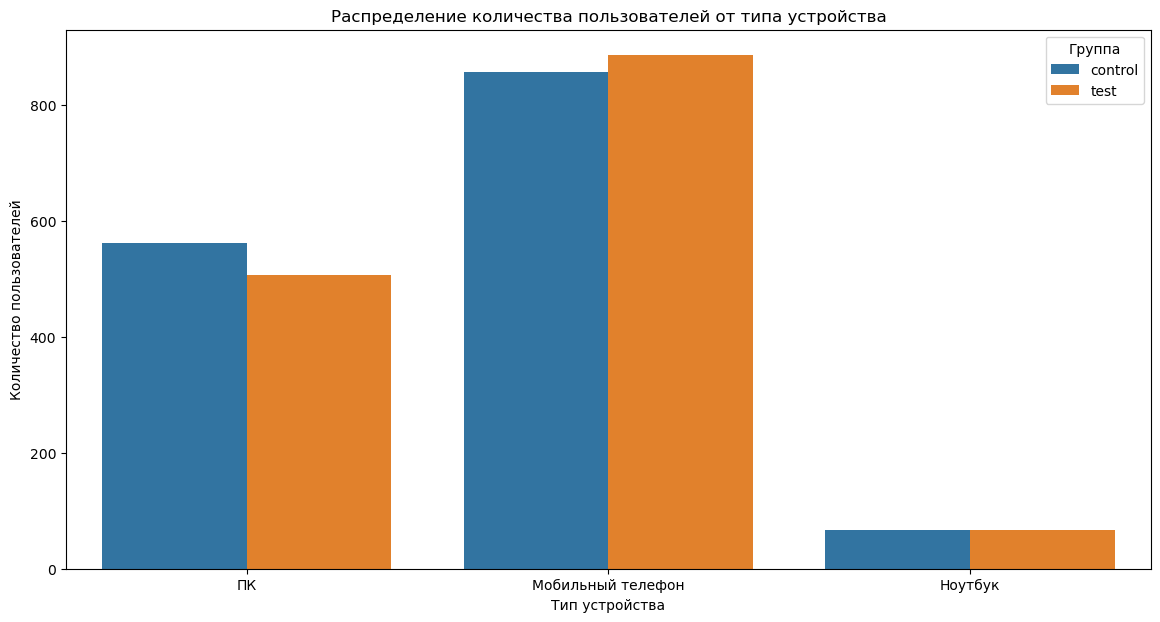

In [16]:
#Дисбаланс пользователей из тестовой и контрольной группы также видно и в группах пользователей с компьютера и с мобильного телефона
plt.figure(figsize = (14,7))
ax = sns.countplot(x = "deviceCategory", hue = "experimentVariant", data  = data)
ax.legend(title='Группа')
ax.set_xlabel("Тип устройства")
ax.set_xticklabels(["ПК", "Мобильный телефон", "Ноутбук"])
ax.set_ylabel("Количество пользователей")
ax.set_title("Распределение количества пользователей от типа устройства")

# 3. Тестирование

Перед проведением A/B тестирования проведём A/A тест. Это необходимо, чтобы убедиться , что пользователи из контрольной группы не отличаются друг от друга

## 3.1. A/A тестирование

In [17]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare

In [18]:
#Отберём значения целевой переменной пользователей из контрольной группы
aa_data = data[data["experimentVariant"] == "control"]["sessionDuration"].values

In [19]:
#Воспользуемся бутстрепом, будем отбирать 25% всех значений
boot_results = bs.bootstrap_ab(test = aa_data, ctrl = aa_data, stat_func = bs_stats.mean, compare_func = bs_compare.difference, return_distribution = True, num_iterations=10000, iteration_batch_size = len(aa_data)/4)

In [20]:
#Зададим границы 95% интервала
borders = np.percentile(boot_results, [2.5, 97.5])

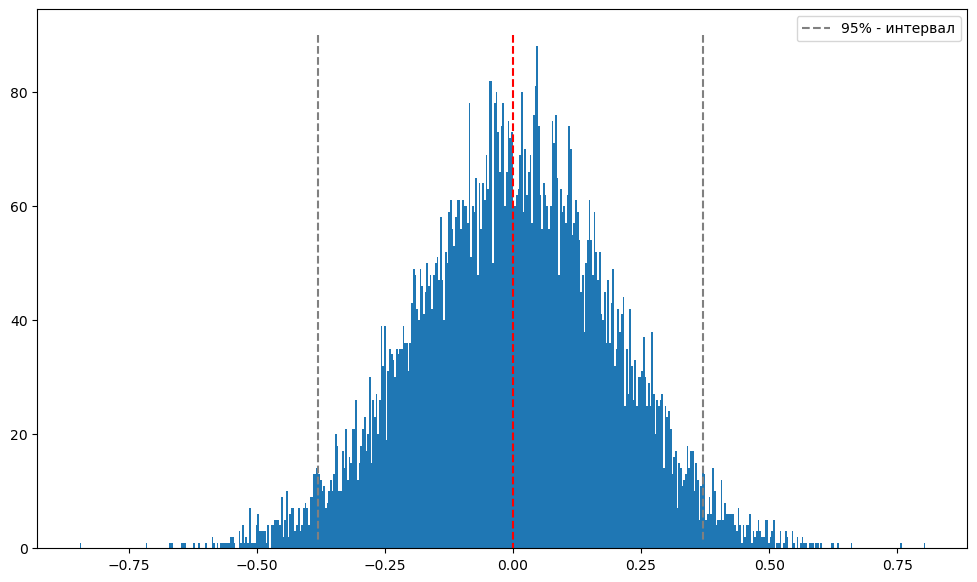

In [21]:
#Отметим наши границы доверительного интервала и нулевое значение
#По результатам A/A теста можно заметить, что  0 входит в распределение разности средних значений
#Значит группа контрольных пользователей однородна
plt.figure(figsize = (12,7))
plt.hist(boot_results, bins = 500)
plt.vlines(borders, ymin = 90, ymax =1, linestyle = '--', colors = "grey", label = "95% - интервал")
plt.vlines(0, ymin = 90, ymax =0.03, linestyle = '--', colors = "red")
plt.legend()
plt.show()

Теперь можно запустить и A/B эксперимент

## 3.2. A/B тестирование

In [22]:
from pingouin import ttest

In [29]:
ttest(data[data["experimentVariant"] == "test"]["sessionDuration"], data[data["experimentVariant"] == "control"]["sessionDuration"], paired=False)


C:\Users\paul\anaconda3\lib\site-packages\pingouin\bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,45.299429,2217.397058,two-sided,8.574658e-318,"[12.46, 13.58]",1.678653,inf,1.0


Мы обнаружили значимое отличие на уровне <<1% для тестовой и контрольной группы. В дополнение обнаружили, что данное изменение привело к увеличению времени нахождения на сайте пользоватлея от 12.46 до 13.58 временных единиц, что является улучшением в 10% от среднего значения времени пользователей из контрольной группы.Другой вопрос в том, насколько мы можем доверять полученным результатам. Уже в разделе анализа сегментов мы увидели, что присутствует дисбаланс пользователей, а значит необходимо починить систему сплитования. Из-за такой системы и могло возникнуть наблюдаемое различие. 

Посчитаем среднее значение времени на сайте для каждой группы категоральной переменной.

# 4. Выводы

В данном исследовании удалось обнаружить значимое различие среднего значения нахождения пользователя на сайте в тестовой и контрольной группе. Была принята альтернативная гипотеза о том, что изменение на сайте привело к 10% улучшению метрики. Но не стоит радоваться данному резлуьтату, потому что был выявлен брак в системе сплитования и группы пользователей по устройствам в тестовой и контрольной получились неравномерными.